## Zeiss Coding Challenge: Data Scientist
**Handling gaps in time series dataset from temperature readings for the development of anomaly detection algorithm.**

Author: Maximilian Kapsecker <br>
Contact: max.kapsecker@gmail.com <br>

### 1. Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from astropy.timeseries import LombScargle
from sklearn.mixture import GaussianMixture
from src.helper import Helper
from src.window_generator import WindowGenerator

In [2]:
# fostering reproducibility for "random" computations
SEED = 42

### 2. Data Loading and Overview

The data source could be a cloud bucket, a database, or any interface for streaming data.

In [3]:
df = pd.read_csv("./data/sample_temperature_data_for_coding_challenge.csv")

In [4]:
df.head(4)

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13T17:51:16.000+0000,heating_temperature,33.3
1,MICDEV001,2019-04-13T17:51:16.000+0000,cooling_temperature,15.0
2,MICDEV001,2019-04-13T18:51:18.000+0000,heating_temperature,34.0
3,MICDEV001,2019-04-13T19:51:20.000+0000,heating_temperature,33.8


Additionally, depending on the context, it might be beneficial to consider external data, such as general weather conditions, e.g, if the device or measurement is exposed to sunlight.

In [5]:
Helper.print_unique_column_entries(df, 5)

Column 'source_id' of type 'object': ['MICDEV001']
Column 'datetime' of type 'object': Has more than 5 unique entries
Column 'property_name' of type 'object': ['heating_temperature' 'cooling_temperature']
Column 'temperature' of type 'float64': Has more than 5 unique entries


In [6]:
df.groupby("property_name").describe()

temperature                                               \
                          count       mean       std   min   25%   50%   75%   
property_name                                                                  
cooling_temperature       301.0  21.295681  6.763378  14.9  15.0  20.8  28.5   
heating_temperature       699.0  33.075393  3.363579  21.7  32.5  34.2  34.8   

                           
                      max  
property_name              
cooling_temperature  33.6  
heating_temperature  39.4

<br>From the overview we assume:
- The data comes from a single source, potentially a microcontroller
- The central measured value is the temperature -- probably in degrees Celsius
- The temperature values are divided into either heating or cooling.
- Some heating and cooling information is available for exactly the same timestamp (e.g., row ```0``` and ```1```), which means that it is not a real-time measurement of the current system temperature, but a kind of calculated property that determines the setpoints for activating cooling or heating mode.

<b>Assumption 1:</b> The data comes from a single microcontroller that specifies the target temperatures [C°] at which either cooling or heating is to take place.

### 3. Data Preprocessing

For reasons of simplicity and visualization, the ```property_names``` entries are renamed. Further, to avoid errors when accessing the ```property_name```, e.g., filtering , we save the two category names as constants.

In [7]:
PROP_HEATING = "Heating"
PROP_COOLING = "Cooling"
df.property_name = df.property_name.replace("heating_temperature", PROP_HEATING).replace("cooling_temperature", PROP_COOLING)

Based on the insights from the overview, we infer the datatypes and cast the column entries accordingly.

In [8]:
df = df.astype({"source_id": 'category', "property_name": 'category', "temperature": 'float64'})

In [9]:
# No errors with the following command -> all entries represent a valid datetime 
df.datetime = pd.to_datetime(df.datetime)

In [10]:
print("Do we have any NaN inside the dataframe:", df.isnull().values.any())

Do we have any NaN inside the dataframe: False


For the purpose of this analysis, some operations might yield wrong results if the rows are not sorted by datetime, e.g., taking the time difference of two subsequent rows. Therefore, we sort the dateframe by the datetime column.

In [11]:
df.sort_values("datetime", inplace=True)

The column ```source_id``` can be removed from the following analysis because it contains only a single unique entry. Dropping it offers advantages in terms of computing resources, specifically when the size of the table grows fast. However, please note that if a more generalized solution is needed, <b>keeping the column might be necessary</b>, as there could be multiple sources requiring different handling.

In [12]:
df.drop("source_id", axis=1, inplace=True)

### 4. Explorative Data Analysis
The objective of the exploratory data analysis (EDA) is twofold:
- To gain insights into the data through visualizations, simple statistics, and pattern analysis. The aim here is to ask relevant questions that contribute to a better understanding of the data.
- To refine the task formulation based on the overall title: _Handling gaps in a time series dataset from temperature readings for the development of an anomaly detection algorithm._

#### 4.1. Trends and Seasonality: How does the timeseries look like at different scales?

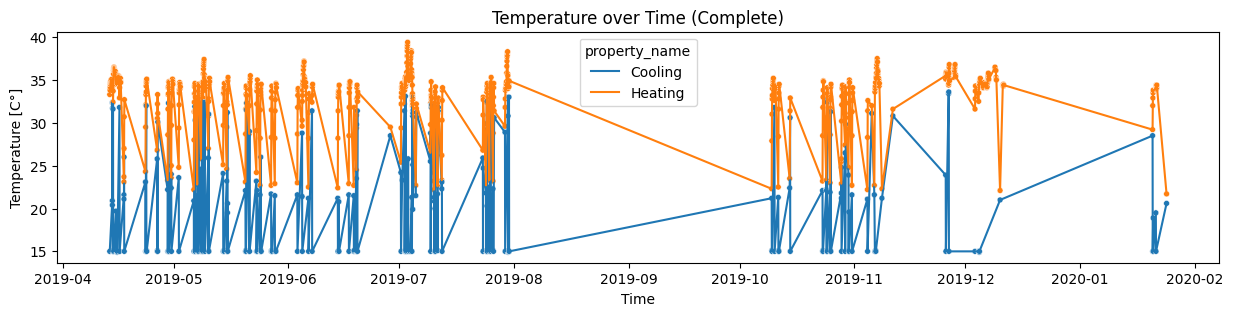

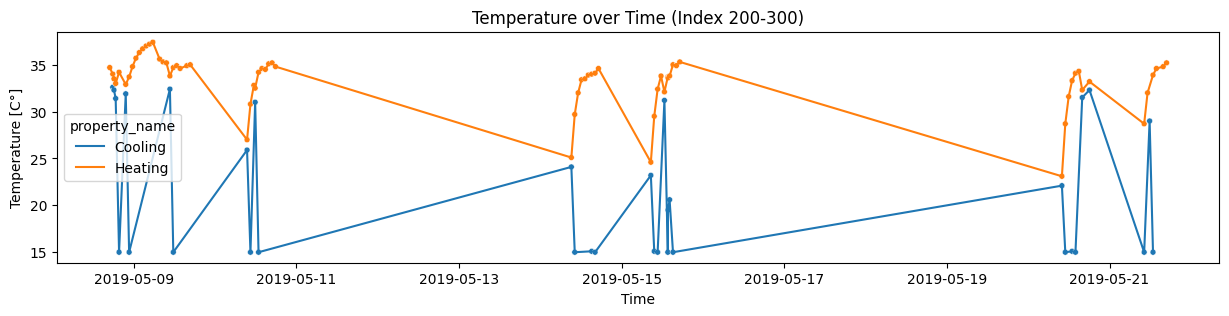

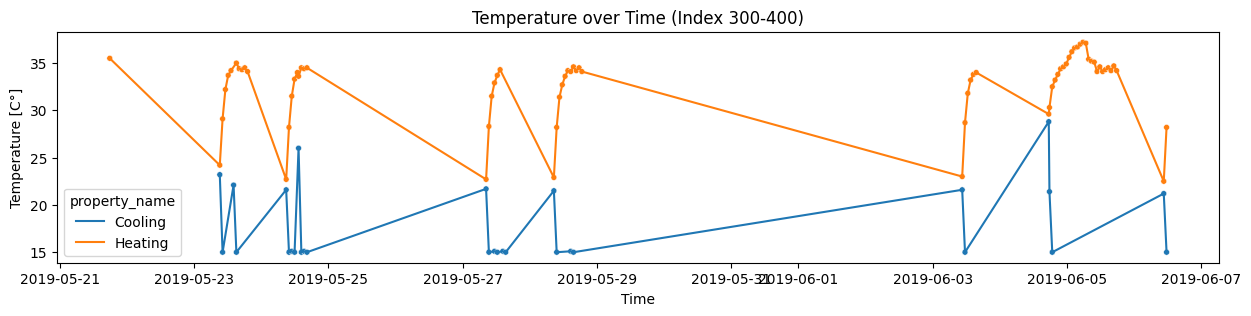

In [13]:
variants = [(None, None, "(Complete)"), (200, 300, "(Index 200-300)"), (300, 400, "(Index 300-400)")]
for k in variants:
    Helper.plot_time_series(
        df, x_col="datetime", y_col="temperature", hue_col="property_name",
        title=f"Temperature over Time {k[2]}",xlabel="Time", ylabel="Temperature [C°]",
        start=k[0], end=k[1], scatter=True,
    )

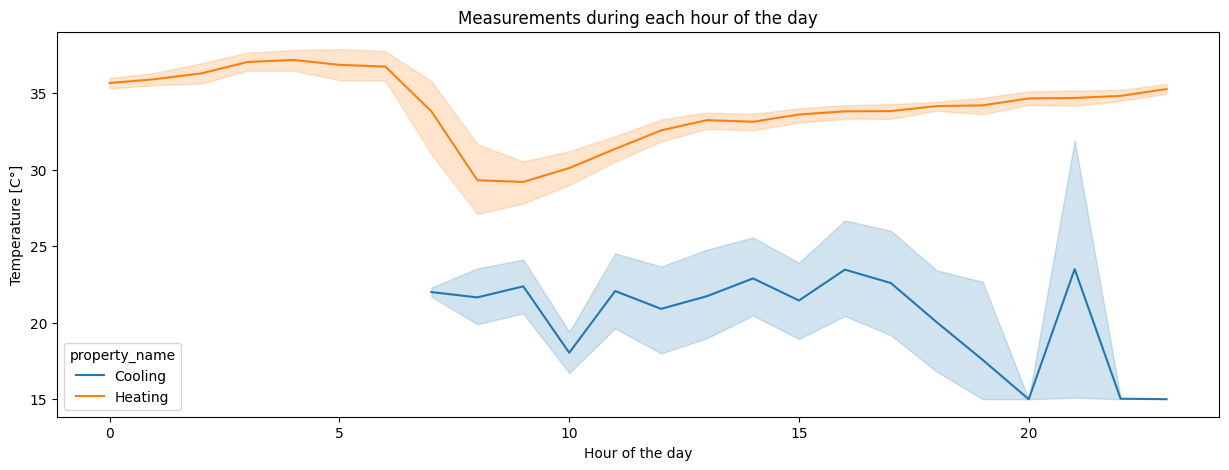

In [14]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df.datetime.dt.hour, y=df.temperature, hue=df.property_name)
plt.title("Measurements during each hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Temperature [C°]")
plt.show()

- <b>Insight 1:</b> The timeseries data shows a non-equidistant distribution, likely caused by irregular sampling or missing values. Additionally, there is no trend visible; however, there may be a seasonal pattern that cannot be quantified through visual inspection alone.

- <b>Insight 2:</b> Some gaps are that broad such that later interpolating these values might be not feasible, given the existing information (.e.g., ```2019-08``` to ```2019-10```).

- <b>Insight 3:</b> The cooling system does not provide any information for the period from 0-6 am. The heating system seems to maintain a fairly constant temperature per hour, which indicates a periodicity of 24 hours.

It would be convenient to use classical FFT at this point to find out more about the periodicity of the signal. However, this is problematic due to the non-equidistant sampling of the data. Therefore, we use Lomb-Scargle Periodograms to investigate periodicity, i.e., finding seasonal behavior in unevenely spaced data [1,2].

[1] _Lomb, N. R. (1976). Least-squares frequency analysis of unequally spaced data. Astrophysics and space science, 39, 447-462._<br>
[2] _Scargle, J. D. (1982). Studies in astronomical time series analysis. II-Statistical aspects of spectral analysis of unevenly spaced data. Astrophysical Journal, Part 1, vol. 263, Dec. 15, 1982, p. 835-853., 263, 835-853._

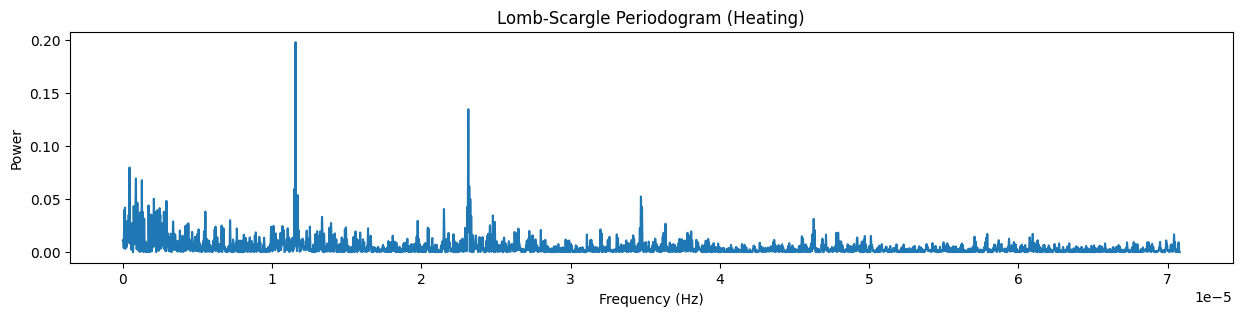

The detected frequencies (hour, power) in descending order: [(24.0, 0.2), (12.0, 0.13), (618.0, 0.08)]


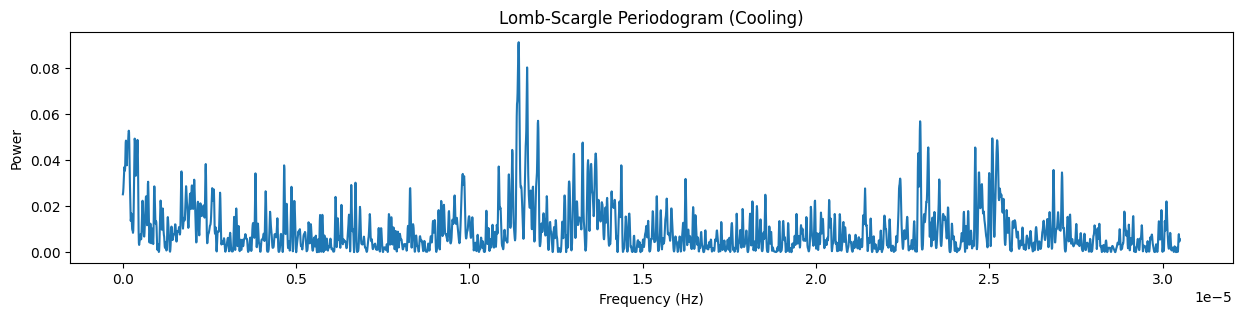

The detected frequencies (hour, power) in descending order: [(24.0, 0.09)]


In [15]:
for k in [PROP_HEATING, PROP_COOLING]:
    temp_series = df[df.property_name.isin([k])].copy()
    
    # converting datetime into seconds passed from first sample [t] and extracting temperature [y]
    temp_series.datetime = temp_series.datetime - np.min(temp_series.datetime)
    t = temp_series.datetime.dt.seconds + temp_series.datetime.dt.days*24*60*60
    y = temp_series.temperature

    # applying the Lomb-Scargle Periodograms and plotting the result
    frequency, power = LombScargle(t, y).autopower()
    frequencies = pd.DataFrame([frequency, power]).transpose()
    frequencies.columns = ['frequency', 'power']
    Helper.plot_time_series(
        frequencies, x_col="frequency", y_col="power",
        title=f'Lomb-Scargle Periodogram ({k})', xlabel="Frequency (Hz)", ylabel="Power",
    )

    # find the ten most "powerful" frequencies
    indices = np.argpartition(-power, 10)[:10]
    indices = indices[np.argsort(-power[indices])]
    max_frequency = frequency[indices]
    
    # convert frequencies from Hz back to hours and print out the detected periodicities
    period = np.round((1 / max_frequency) / 3600, 1) 
    print("The detected frequencies (hour, power) in descending order:", Helper.print_distinct_values(period, power[indices], 2))

- <b>Insights 4:</b> There are signs of seasonality in the data, particularly for the heating time series. It shows a recurring pattern after 24 hours (power: 0.2), 12 hours (power: 0.13) and little after 8 hours (power: 0.05). For the cooling series there is a relatively weak recurring pattern in 24 hour periods (power: 0.09).

#### 4.2. Sampling rate: What would be a good frequency?

To obtain an equidistant sampling rate, which is required for different machine learning approaches, an appropriate sampling rate must be determined. Though the objective is to obtain a fine-grained time series, the sampling rate should not be so high that the generation of the missing values becomes impractical. Based on the previous analysis, an hourly sampling rate seems to be suitable. To confirm this, we want to examine the distribution of time gaps.

In [16]:
# Add two columns that present the difference in temperature/time to the preceding sample, grouped by heating and cooling
df[['time_diff', 'temp_diff']] = df.groupby('property_name', observed=False)[['datetime', 'temperature']].diff()

# It is more convenient to transform the datetime difference into seconds, i.e., a numeric value, for further processing.
df['time_diff'] = df.time_diff.dt.days * 24 * 3600.0 + df.time_diff.dt.seconds

# The first two rows are nan, as they was no preceding sample -> filling with the median (robust in regards to outier)
df[["time_diff", "temp_diff"]] = df[["time_diff", "temp_diff"]].apply(lambda x: x.fillna(x.median()), axis=0)

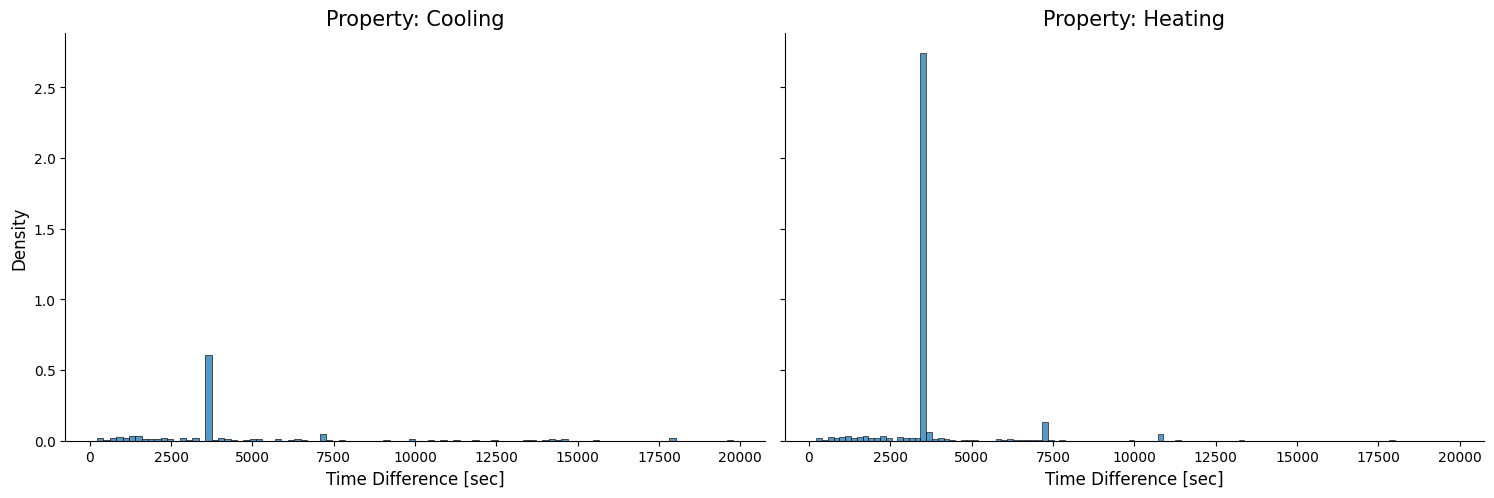

Most occuring (n=487) time difference for Heating: 3427.58
Most occuring (n=118) time difference for Cooling: 3549.99


In [17]:
SECONDS_SIX_HOURS = 3600*6
BINS = 100

# Filtering to samples with timestep of less than six hours (sampling rate is liekly smaller) to not skew the histogram
g = sns.FacetGrid(df[df.time_diff < SECONDS_SIX_HOURS], col="property_name", height=5, aspect=1.5)
g.map_dataframe(sns.histplot, x="time_diff", bins=BINS, stat="frequency")
g.set_axis_labels("Time Difference [sec]", "Density")
g.set_titles(col_template="Property: {col_name}", size=15)
g.set_xlabels(size=12)
g.set_ylabels(size=12)
plt.show()

# Supporting the visual histplot by creating a histogram and printing the most occuring value as numeric value
for k in [PROP_HEATING, PROP_COOLING]:
    temp = df[(df.property_name.isin([k])) & (df.time_diff < SECONDS_SIX_HOURS)].copy()
    histogram = np.histogram(temp.time_diff[1:], BINS)
    i_max = np.argmax(histogram[0])
    print(f"Most occuring (n={histogram[0][i_max]}) time difference for {k}:", histogram[1][i_max])

- <b>Insight 5:</b> The majority of sampled time steps have a distance of ~one hour and makes it a suitable candidate for sampling rate when turning the timeseries evenly spaced.

#### 4.3. Transition Probabilities: How are the temperature and the n-th order difference distributed?

We plot histograms to understand the distribution of temperature and the differences between consecutive measurements for both the cooling and heating data.

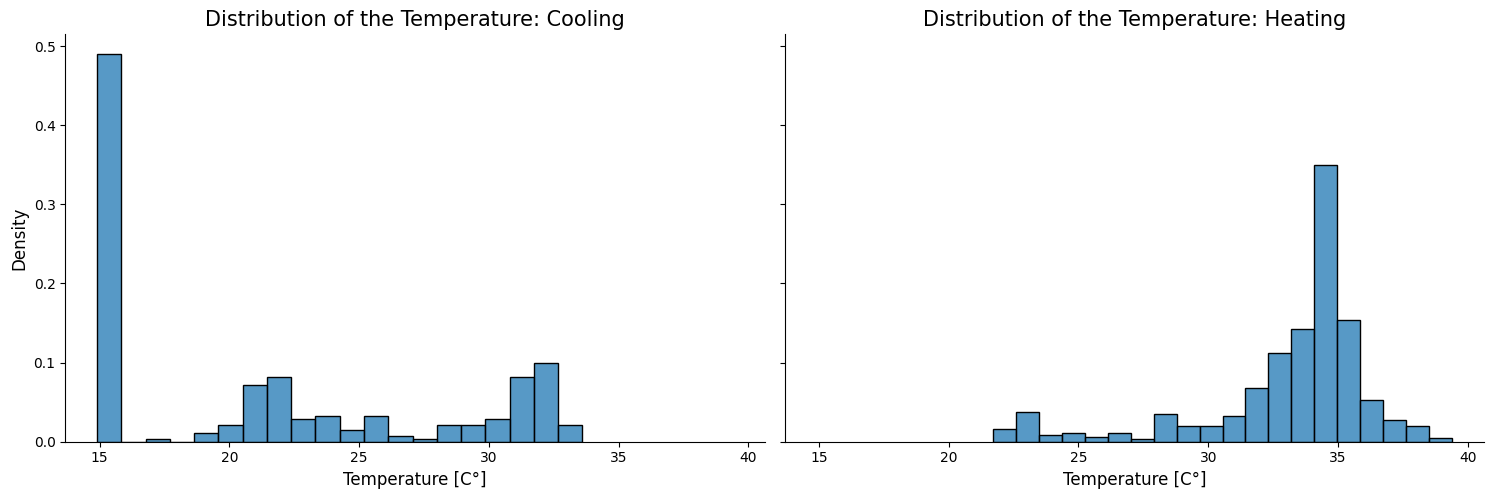

In [18]:
g = sns.FacetGrid(df, col="property_name", height=5, aspect=1.5)
g.map_dataframe(sns.histplot, x="temperature", bins=20, stat='density')
g.set_axis_labels("Temperature [C°]", "Density")
g.set_titles(col_template="Distribution of the Temperature: {col_name}", size=15)
g.set_xlabels(size=12)
g.set_ylabels(size=12)
plt.show()

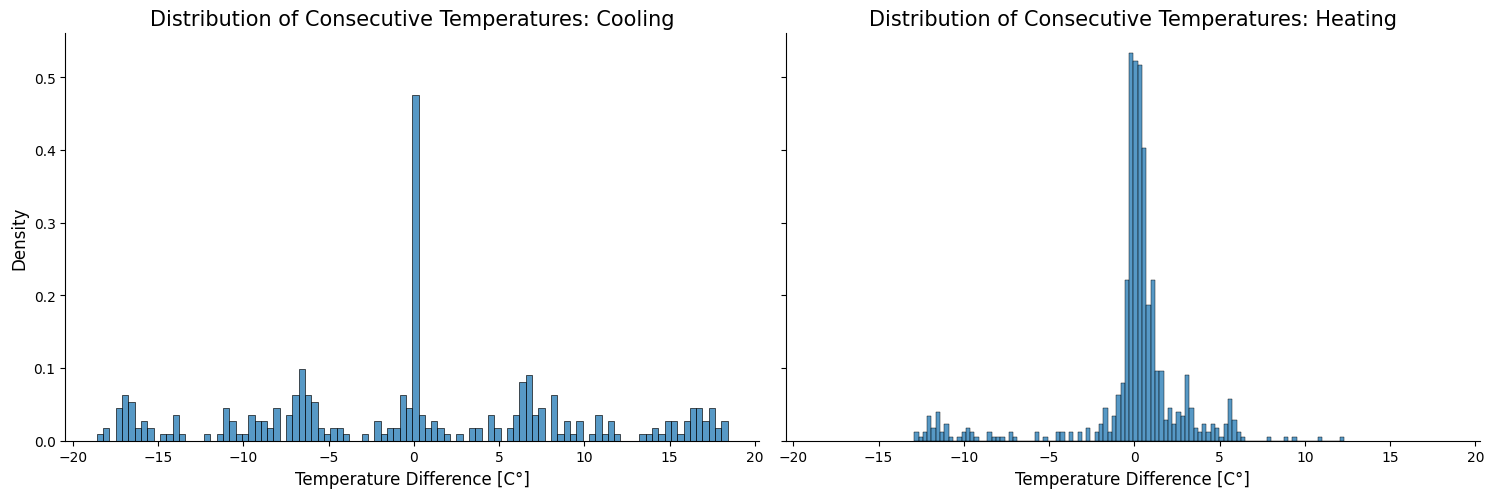

In [19]:
g = sns.FacetGrid(df, col="property_name", height=5, aspect=1.5)
g.map_dataframe(sns.histplot, x="temp_diff", bins=100, stat='density')
g.set_axis_labels("Temperature Difference [C°]", "Density")
g.set_titles(col_template="Distribution of Consecutive Temperatures: {col_name}", size=15)
g.set_xlabels(size=12)
g.set_ylabels(size=12)
plt.show()

- <b>Insight 6:</b> All histograms suggest a Gaussian pattern in the distribution of temperature and adjacent values. Specifically, the temperatures of the heating system appear to follow a normal distribution, while the cooling system shows a Gaussian mixture distribution with three peaks in the top graph and five peaks in the bottom graph. Formally, let $X_{t}$ represent the heating temperature at time $t$ and $Y_{t}$ represent the cooling temperature at time $t$. Thus, we infer:
  - $P(X_{t}) \sim \mathcal{N}(\mu, \sigma)$
  - $P(X_{t-1} - X_{t}) \sim \mathcal{N}(\mu, \sigma)$
  - $P(Y_{t}) \sim \sum_{i=1}^{3} \pi_{i} \mathcal{N}(\mu_{i}, \sigma_{i})$
  - $P(Y_{t-1} - Y_{t}) \sim \sum_{i=1}^{5} \pi_{i} \mathcal{N}(\mu_{i}, \sigma_{i})$

While most samples align with the targeted hourly sampling frequency, caution is needed when inferring a distribution for the differences between consecutive values. The timesteps are not equidistant and may not accurately represent the true hourly interval distribution. To address this, we extend the histogram analysis by incorporating a time-axis, evaluating not only with a ```lag=1``` but also up to the previous 50 lines.

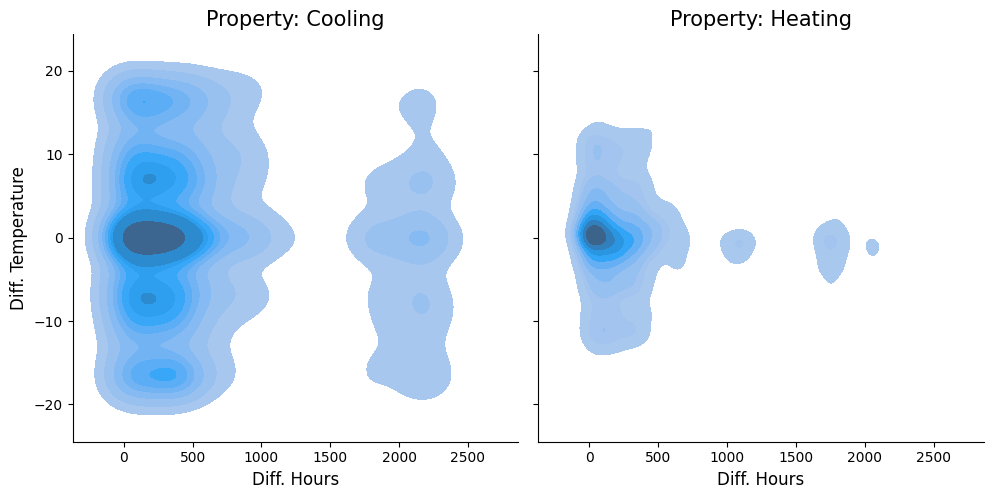

In [20]:
temperatue_lags = pd.DataFrame()
lags = range(1, 50)

# calculate the temperature difference for 1...50 lags
for k in lags:
    temp = df.groupby('property_name', observed=False)[['datetime', 'temperature']].diff(k)
    temp['property_name'] = df.property_name
    temperatue_lags = pd.concat([temperatue_lags, temp])

# with calculating lags for 1...50, nan values arise, which we cannot use for this analysis
temperatue_lags.dropna(inplace=True)
temperatue_lags.reset_index(drop=True, inplace=True)
temperatue_lags.datetime = temperatue_lags.datetime.dt.days*24 + temperatue_lags.datetime.dt.seconds / 3600.0
temperatue_lags.datetime = temperatue_lags.datetime.astype(int)

g = sns.FacetGrid(temperatue_lags, col="property_name", height=5, aspect=1)
g.map_dataframe(sns.kdeplot, x="datetime", y="temperature", fill=True)
g.set_axis_labels("Diff. Hours", "Diff. Temperature")
g.set_titles(col_template="Property: {col_name}", size=15)
g.set_xlabels(size=12)
g.set_ylabels(size=12)
plt.show()

- <b>Insight 7:</b> Both Gaussian mixture like distribution are also observable when an additional axis represents the time gap between two measurements.


- <b>Simplification:</b> We assume a normal distribution as a prior for the heating values (```temperature``` and ```temp_diff```) and a Gaussian mixture model for the cooling values. This assumption will be particularly useful later when filling in missing data in the time series using transition probabilities. A more complex approach would involve modeling the joint distribution of temperature changes over a given time period and using the marginal distribution of temperature when necessary.

In [21]:
# Fitting a Gaussian Mixture distribution for the different scenarios
# Note: When n_components=1 the Gaussian Mixture distribution "collapses" to a Gaussian distribution
gm_heating_d = GaussianMixture(n_components=1).fit(df[df.property_name == PROP_HEATING].temperature.values.reshape(-1,1))
gm_cooling_d = GaussianMixture(n_components=5).fit(df[df.property_name == PROP_COOLING].temperature.values.reshape(-1,1))
gm_heating_t = GaussianMixture(n_components=1).fit(df[df.property_name == PROP_HEATING].temperature.values.reshape(-1,1))
gm_cooling_t = GaussianMixture(n_components=3).fit(df[df.property_name == PROP_COOLING].temperature.values.reshape(-1,1))

#### 4.4. Interaction: What is the relation of heating and cooling temperature?

Not only the series itself can show anomalies, but also the interaction between the two series. We are therefore interested in whether we can derive any patterns from the gap between warming and cooling, which is also a time series. Therefore, we follow the same approach as in previous section.

In [22]:
# Identify samples for which we have cooling and heating information at the same time
index_duplicates = df[df.datetime.duplicated()].datetime
df_res = Helper.calculate_difference_timeseries(df[df.datetime.isin(index_duplicates)])
df_res.columns = ["datetime", "residuals", "heating", "cooling"]
df_res.datetime = pd.to_datetime(df_res.datetime)
df_res["res_diff"] = df_res.residuals.diff()
df_res.res_diff =  df_res.res_diff.fillna(df_res.res_diff.median())

In [23]:
df_res.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
residuals,284.0,9.560211,8.013976,0.6,1.100,12.85,17.925,21.4
heating,284.0,30.758099,4.003855,21.7,28.575,32.40,33.900,36.4
cooling,284.0,21.197887,6.709562,14.9,15.000,20.70,26.975,33.6
res_diff,284.0,-0.060211,12.002120,-19.7,-12.400,0.10,11.900,20.0


<Axes: xlabel='residuals', ylabel='Count'>

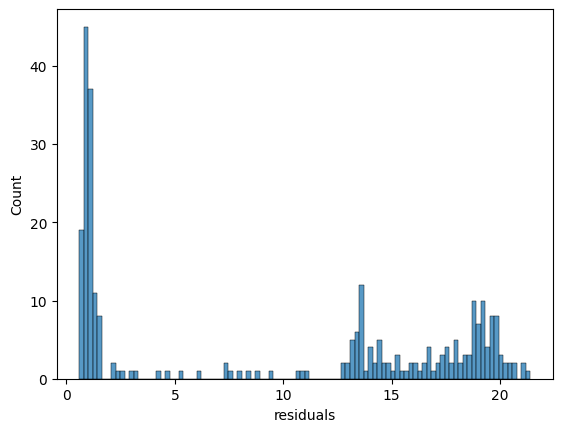

In [24]:
sns.histplot(df_res.residuals, bins=100)

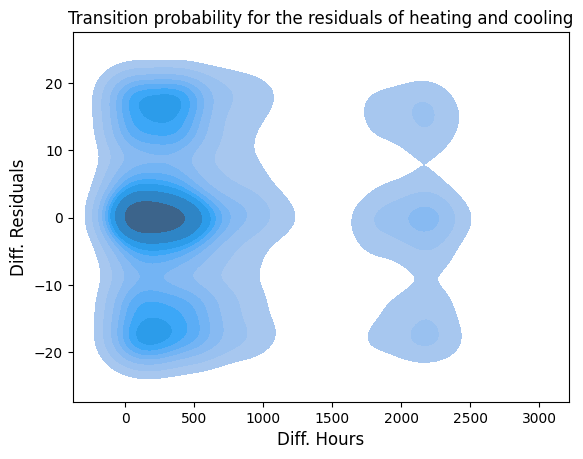

In [25]:
res_list = [df_res[['datetime', 'residuals']].diff(k) for k in range(1, 50)]
residual_lags = pd.concat(res_list, ignore_index=True)
residual_lags['datetime'] = residual_lags['datetime'].dt.days * 24 + residual_lags['datetime'].dt.seconds / 3600.0
residual_lags.dropna(inplace=True)
residual_lags['datetime'] = residual_lags['datetime'].astype(int)

g = sns.kdeplot(residual_lags, x="datetime", y="residuals", fill=True)
g.set_title("Transition probability for the residuals of heating and cooling")
g.set_xlabel("Diff. Hours", size=12)
g.set_ylabel("Diff. Residuals", size=12)
plt.show()

- <b>Insight 8:</b> We visually estimate a Gaussian mixture model (three peaks) for both distributions (it poses a simplifcation as well).

In [26]:
# likewise we fit a gaussian mixture distribution for the residual values
gm_residuals_t = GaussianMixture(n_components=3).fit(df_res.residuals.values.reshape(-1,1))
gm_residuals_d = GaussianMixture(n_components=3).fit(df_res.res_diff.values.reshape(-1,1))

### 5. Modelling

From the explorative data analysis, we infer the following task specification:
- <b>Task 1:</b> Address the missing values in the time series, considering the known seasonality patterns and fitted distributions.
- <b>Task 2:</b> Identify anomalies in the temperature system, whether they occur in the heating system, cooling system, or both.

#### 5.1. How about a first baseline anomaly detection model?

As a baseline anomaly detection model, we can use the fitted distributions and look for associated values with a low occurence probability. 

In [27]:
# Define a constant [in %] for the quantile, which sets the static threshold for detecting anomalies
QUANTILE_OUTLIER = 5

In [28]:
# Based on our six fitted distributions, we can identify six anomalies
anomaly_columns = [
    "outlier_heating_d", "outlier_cooling_d", "outlier_residuals_d",
    "outlier_heating_t", "outlier_cooling_t", "outlier_residuals_t",
]
df[anomaly_columns] = False

In [29]:
# calculate for each sample the probability of occurence
proba_heating_t = np.exp(gm_heating_t.score_samples(df[df.property_name == PROP_HEATING].temperature.values.reshape(-1,1)))
proba_cooling_t = np.exp(gm_cooling_t.score_samples(df[df.property_name == PROP_COOLING].temperature.values.reshape(-1,1)))
proba_residuals_t = np.exp(gm_residuals_t.score_samples(df_res.residuals.values.reshape(-1,1)))

proba_heating_d = np.exp(gm_heating_d.score_samples(df[df.property_name == PROP_HEATING].temp_diff.values.reshape(-1,1)))
proba_cooling_d = np.exp(gm_cooling_d.score_samples(df[df.property_name == PROP_COOLING].temp_diff.values.reshape(-1,1)))
proba_residuals_d = np.exp(gm_residuals_d.score_samples(df_res.residuals.values.reshape(-1,1)))

# Define the threshold for anomalies based on the quantiles of the probabilities of occurrence
quantile_heating_t = np.percentile(proba_heating_t, QUANTILE_OUTLIER)
quantile_cooling_t = np.percentile(proba_cooling_t, QUANTILE_OUTLIER)
quantile_residuals_t = np.percentile(proba_residuals_t, QUANTILE_OUTLIER)

quantile_heating_d = np.percentile(proba_heating_d, QUANTILE_OUTLIER)
quantile_cooling_d = np.percentile(proba_heating_d, QUANTILE_OUTLIER)
quantile_residuals_d = np.percentile(proba_heating_d, QUANTILE_OUTLIER)

In [30]:
# Label the samples as anomalies based on the threshold
# Note: Duplicate the residual probabilities since they appear for both cooling and heating
df.loc[df.property_name == PROP_HEATING, "outlier_heating_t"] = proba_heating_t < quantile_heating_t
df.loc[df.property_name == PROP_COOLING, "outlier_cooling_t"] = proba_cooling_t < quantile_cooling_t
df.loc[df.datetime.isin(index_duplicates), "outlier_residual_t"] = np.repeat(proba_residuals_t, 2) < quantile_residuals_t

df.loc[df.property_name == PROP_HEATING, "outlier_heating_d"] = proba_heating_d < quantile_heating_d
df.loc[df.property_name == PROP_COOLING, "outlier_cooling_d"] = proba_cooling_d < quantile_cooling_d
df.loc[df.datetime.isin(index_duplicates), "outlier_residual_d"] = np.repeat(proba_residuals_d, 2) < quantile_residuals_d


df["outlier_score"] = df.outlier_heating_t.astype(int) + df.outlier_cooling_t.astype(int) + df.outlier_residuals_t.astype(int) +  df.outlier_heating_d.astype(int) + df.outlier_cooling_d.astype(int) + df.outlier_residuals_d.astype(int)

Let's have a look at the detected anomalies from our first attempt.

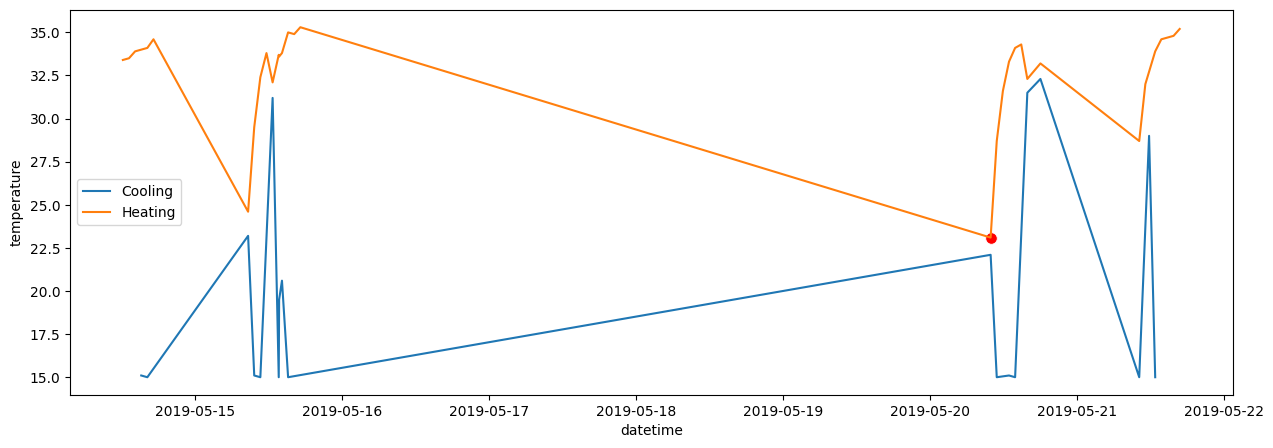

In [31]:
zoom = df.iloc[250:300,:]
plt.figure(figsize=(15,5))
sns.lineplot(zoom, x='datetime', y='temperature', hue="property_name")
for k in anomaly_columns:
    sns.scatterplot(zoom[(zoom[k] == True) & (zoom["outlier_score"] > 1)], x='datetime', y='temperature', color='red', s=70, marker='o')

In [32]:
print("Total number of outliers:", len(df[df["outlier_score"] > 1].datetime.unique()))

Total number of outliers: 38


#### 5.2. Missing Values and Data Augmentation

There are various methods for interpolating missing values, such as forward/backward fill, linear interpolation, and spline interpolation. However, the challenge with the current time series is the large gaps between measurements. Fortunately, we have some knowledge of the generating factors. The primary goal is not to reconstruct the time series exactly (which is likely not feasible), but to capture the generative factors such as seasonality and the transition probabilities. This approach aims to ensure that the subsequent training of a machine learning model for outlier detection is based on iid data. However, for really large gaps, error propagation and the associated uncertainty quantification might be so high that interpolation may not be feasible. Therefore, we add a marker so that, on demand, the respective sequences can be excluded.

In [33]:
# Introduce a constant that marks breaks in timeseries
MAX_TIMEGAP_SECONDS = 3600*24 # one day
larger_defined_timegap = df['time_diff'] > MAX_TIMEGAP_SECONDS
# Additionally, we need to set the breakpoint at the preceding sample to indicate the start of the gap
index_heating = df.property_name == PROP_HEATING
index_cooling = df.property_name == PROP_COOLING
for k in [PROP_HEATING, PROP_COOLING]:
    index = df.property_name == k
    df.loc[index, 'break'] = larger_defined_timegap[index] | larger_defined_timegap[index].shift(-1, fill_value=False)

In [34]:
# Finally, let's aggregate the data into one-hour intervals using the mean for temperatures.
# Hours with no available values will be assigned NaN.
df.set_index("datetime", inplace=True)
df = pd.DataFrame(df.groupby(by=["property_name", pd.Grouper(freq='1h')], observed=False).agg({
    "temperature": 'mean',
    "break": 'max',
})).reset_index()

In [35]:
# Split into a heating and cooling series
# Note: The timeseries for cooling and heating have identical start and end timestamps
# No need to artificially extend either series to align their start and end times.
series_heating = df[df.property_name == PROP_HEATING][['datetime', 'temperature', 'break']]
series_cooling = df[df.property_name == PROP_COOLING][['datetime', 'temperature', 'break']]

In [36]:
# Fill the NaN values in the series using seasonality information.
# The function iteratively fills NaNs when a value is available for the same time in the past, based on the specified seasonality.
# The recursive process stops when the series is no longer updating.
# To prevent repeatedly propagating an outlier, the function checks for outliers using the provided distribution.
# Note: For simplicity, we are only using the temperature distribution, not the distribution of consecutive values
series_heating.temperature = Helper.fill_nan_from_seasonality(series_heating.temperature, 24, gm_heating_t, quantile_heating_t)
series_heating.temperature = Helper.fill_nan_from_seasonality(series_heating.temperature, 12, gm_heating_t, quantile_heating_t)
series_cooling.temperature = Helper.fill_nan_from_seasonality(series_cooling.temperature, 24, gm_cooling_t, quantile_cooling_t)

In [37]:
# Fill the remaining missing values by sampling from the temperature distributions
# Note: Also here we'd generate better results when including the distribution on consectuive values as well
series_heating.temperature = Helper.fill_nan_from_distribution(series_heating.temperature, gm_heating_t).copy()
series_cooling.temperature = Helper.fill_nan_from_distribution(series_cooling.temperature, gm_cooling_t).copy()

/Users/max/Desktop/zeiss/src/helper.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[k] = distribution.sample()[0][0, 0]


Let's get an idea of the result

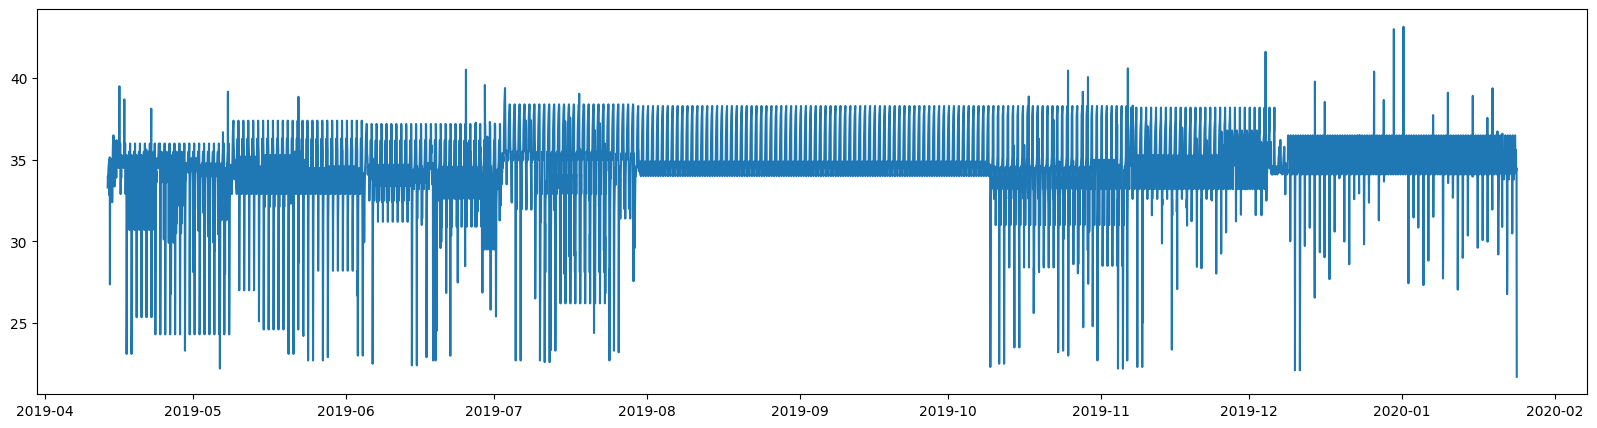

In [38]:
plt.figure(figsize=(20,5))
plt.plot(series_heating.datetime, series_heating.temperature)

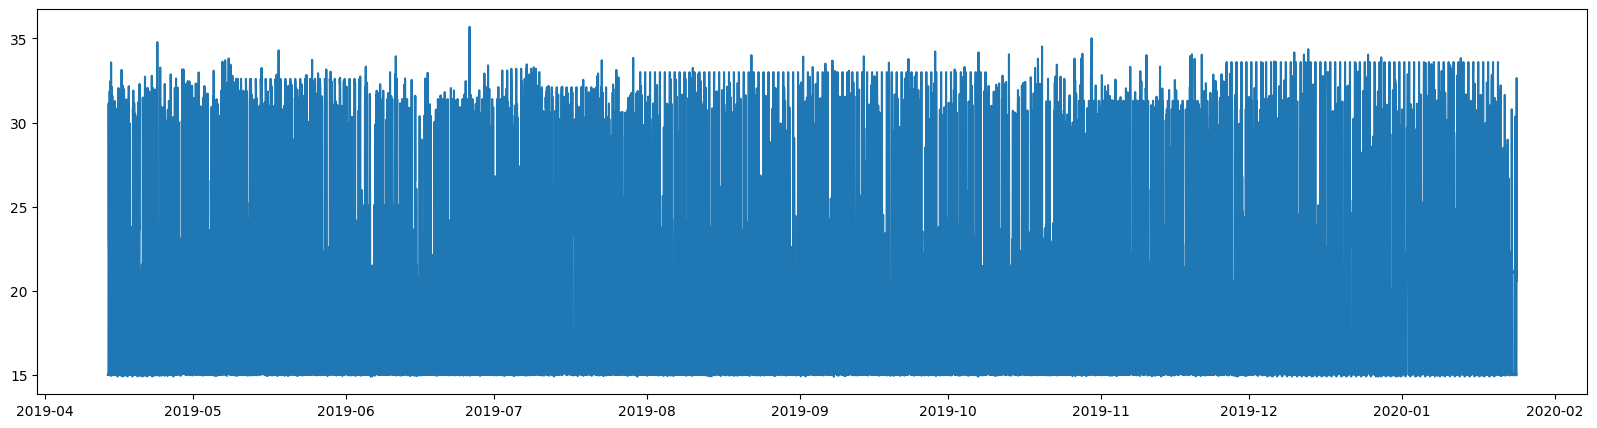

In [39]:
plt.figure(figsize=(20,5))
plt.plot(series_cooling.datetime, series_cooling.temperature)

In [40]:
# It is important for further processing that both series do represent the same dates
assert len(series_heating) == len(series_cooling)

In [41]:
# Due to upsampling, the break column contains NaNs.
# We replace NaNs with True if they are located between True values, and with False otherwise.
series_heating.loc[:,"break"] = series_heating.loc[:,"break"].infer_objects(copy=False)
series_cooling.loc[:,"break"] = series_cooling.loc[:,"break"].infer_objects(copy=False)

For the cooling temperatures, we set the time period from 0:00 to 6:00 AM to True. Although we are currently using the sampled values from this range for simplicity, we may choose to exclude them later.

In [42]:
index_night_time = (series_cooling.datetime.dt.hour >= 0) & (series_cooling.datetime.dt.hour <= 6)
series_cooling.loc[index_night_time, "break"] = True

In [43]:
series_heating.reset_index(inplace=True, drop=True)
series_cooling.reset_index(inplace=True, drop=True)

#### 5.3. Feature Engineering and Split

When splitting data into training, validation, and test sets, it's important to avoid introducing bias. For instance, in the case of a time series, you should partition longer continuous periods for testing rather than selecting individual values at random. If you cut out singular values, the model might simply interpolate and predict the missing values, leading to artificially high performance metrics. Properly segmenting continuous blocks helps ensure the model is genuinely evaluated on unseen data, providing a more accurate measure of its predictive power.

In [44]:
series = series_heating.merge(series_cooling, how="left", on="datetime")
series.columns = ["datetime", "temperature_heating", "break_heating", "temperature_cooling", "break_cooling"]
series["residuals"] = series.temperature_heating - series.temperature_cooling

In [45]:
# For simplicity we are splitting the data linearly by consecutive segments
# However, there is a sound class from sklearn - TimeSeriesSplit - which would be a more professional alternative
n = len(series)
n_train = int(0.8*n)
n_val = int(0.1*n)
n_test = n - n_train - n_val

assert (n_train + n_val + n_test) == n 

train_df= series.loc[0:n_train, ["temperature_heating", "temperature_cooling", "residuals"]]
val_df= series.loc[n_train:(n_train+n_val), ["temperature_heating", "temperature_cooling", "residuals"]]
test_df= series.loc[(n_train+n_val):, ["temperature_heating", "temperature_cooling", "residuals"]]

Furthermore, we want the data to be standardized, as it holds advantages regarding the stability of machine learning algorithms.

In [46]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

The upcoming strategy utilizes a windowing approach that segments the data into windows of length 25 with a step length of 1 (as illustrated in the image below). We aim to use 24 hours of data as the input to predict the value of the 25th hour. This method and its implementation were originally presented by Google, and I would like to acknowledge their contribution: [Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series).

![Window Image](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/raw_window_1h.png)

In [47]:
SERIES_LENGTH=25
window_series = WindowGenerator(
    input_width=SERIES_LENGTH, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['temperature_heating'],
)

In [48]:
example_window = tf.stack([np.array(train_df[:window_series.total_window_size]),
                           np.array(train_df[100:100+window_series.total_window_size]),
                           np.array(train_df[300:300+window_series.total_window_size])])

example_inputs, example_labels = window_series.split_window(example_window)

2024-06-06 19:40:12.432334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-06 19:40:12.432376: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-06 19:40:12.432386: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-06 19:40:12.432424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-06 19:40:12.432441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


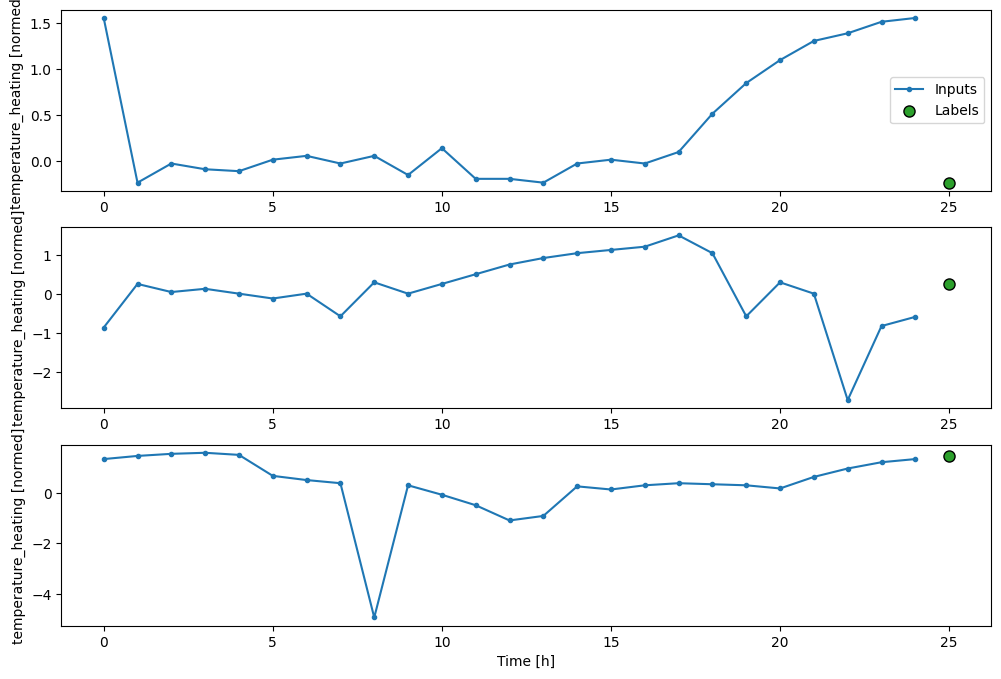

In [49]:
window_series.plot(plot_col='temperature_heating')

#### 5.4. Anomaly Detection

Our approach is to train a model that can predict the next value of our time series. We assume that values with a large residual between the predicted and actual values indicate outliers.

- <b>Simplification:</b> We limit our approach to the heating time series. While it still utilizes cooling temperature and residual data for training and predicting, it does not actively predict anomalies for them. However, extending the model training to these two time series can be done similarly.

In [50]:
# collection of (yet simple) models that allow for an easy extension
model_zoo = {
    'linear': tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Reshape((1, 1)),
    ]),
    'convolution': tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=(24,), activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Reshape([1, -1])
    ]),
    'lstm': tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Reshape([1, -1]),
    ])
}

In [51]:
# standard code for compiling and fitting a tensorflow/keras model
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.legacy.Adam(), # Use this when operating on an M1/M2 Mac, else remove .legacy
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping], verbose=1)
    return history

In [52]:
MAX_EPOCHS = 20
val_performance = {}
performance = {}
models = {}

# Train all the models and store the results (performance and the model itself)
for k in model_zoo:
    print(f"Training and evaluating {k} model")
    model = model_zoo[k]
    history = compile_and_fit(model, window_series)
    val_performance[k] = model.evaluate(window_series.val, return_dict=True)
    performance[k] = model.evaluate(window_series.test, verbose=0, return_dict=True)
    models[k] = model

Training and evaluating linear model
Epoch 1/20
 15/171 [=>............................] - ETA: 0s - loss: 3.3948 - mean_absolute_error: 1.4402  

2024-06-06 19:40:13.261225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 1s 5ms/step - loss: 1.7764 - mean_absolute_error: 0.9736 - val_loss: 0.5584 - val_mean_absolute_error: 0.5204
Epoch 2/20
171/171 [==============================] - 1s 4ms/step - loss: 0.6550 - mean_absolute_error: 0.5279 - val_loss: 0.3281 - val_mean_absolute_error: 0.3335
Epoch 3/20
171/171 [==============================] - 1s 4ms/step - loss: 0.4688 - mean_absolute_error: 0.3886 - val_loss: 0.2749 - val_mean_absolute_error: 0.2762
Epoch 4/20
171/171 [==============================] - 1s 4ms/step - loss: 0.4229 - mean_absolute_error: 0.3362 - val_loss: 0.2595 - val_mean_absolute_error: 0.2611
Epoch 5/20
171/171 [==============================] - 1s 4ms/step - loss: 0.4060 - mean_absolute_error: 0.3112 - val_loss: 0.2506 - val_mean_absolute_error: 0.2518
Epoch 6/20
171/171 [==============================] - 1s 4ms/step - loss: 0.3983 - mean_absolute_error: 0.2981 - val_loss: 0.2484 - val_mean_absolute_error: 0.2478
Epoch 7/20
171/171 [=======

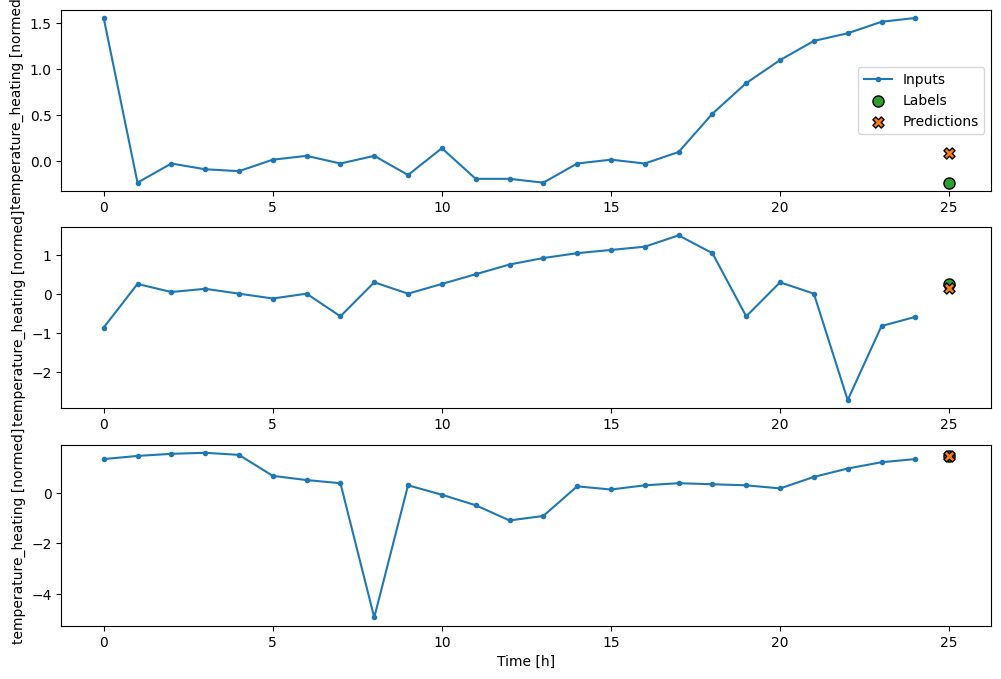

In [53]:
# Exemplary plotting the results for the linear model
window_series.plot(models['linear'], plot_col="temperature_heating")

### 6. Evaluation

Let's evaluate the performance of the models on both the validation and test sets.

In [54]:
df_eval_val = pd.DataFrame(val_performance).transpose()
df_eval_val["Dataset"] = "Validation"

df_eval_test = pd.DataFrame(performance).transpose()
df_eval_test["Dataset"] = "test" 
df_val = pd.concat([df_eval_val, df_eval_test]).reset_index()

Text(0, 0.5, 'Mean Absolute error')

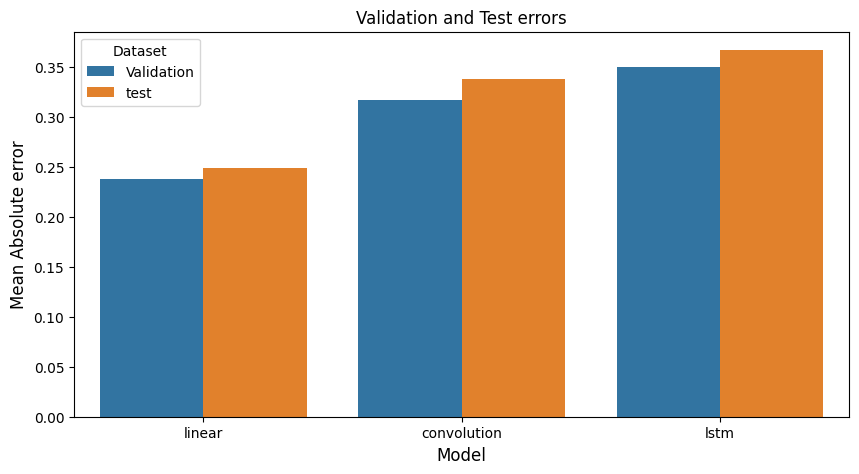

In [55]:
plt.figure(figsize=(10,5))
g = sns.barplot(df_val,x="index", y="mean_absolute_error", hue="Dataset")
g.set_title("Validation and Test errors")
g.set_xlabel("Model", size=12)
g.set_ylabel("Mean Absolute error", size=12)

There is minimal difference in the performance of the models. Therefore, we will use the linear model to illustrate a potential evaluation for outlier detection.

In [56]:
# Predict on the train data set and calculate the difference towards the actual value
result = models['linear'].predict(window_series.train)
difference = result[:, 0, 0] - train_df[SERIES_LENGTH:].temperature_heating

171/171 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Count')

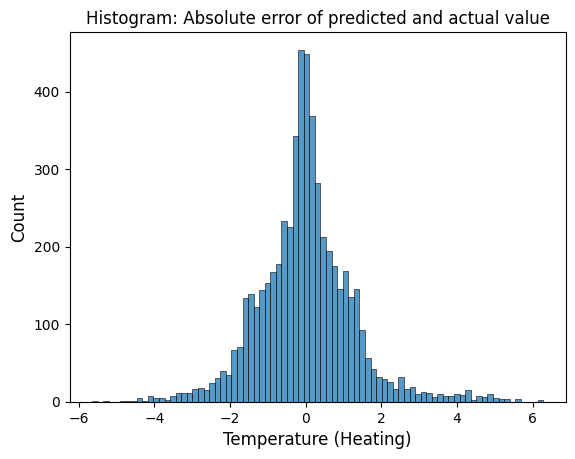

In [57]:
g = sns.histplot(difference)
g.set_title("Histogram: Absolute error of predicted and actual value")
g.set_xlabel("Temperature (Heating)", size=12)
g.set_ylabel("Count", size=12)

In [58]:
# calculate the outlier thresholds for both sides of the distribution based on the difference values
bounds = np.quantile(difference, [QUANTILE_OUTLIER/2.0/100.0, 1-QUANTILE_OUTLIER/2.0/100.0])

In [59]:
# Calculate the difference of prediction and actual value
train_df["difference"] = models['linear'].predict(window_series.train)[:, 0, 0] - train_df[SERIES_LENGTH:].temperature_heating
val_df["difference"] = models['linear'].predict(window_series.val)[:, 0, 0] - val_df[SERIES_LENGTH:].temperature_heating
test_df["difference"] = models['linear'].predict(window_series.test)[:, 0, 0] - test_df[SERIES_LENGTH:].temperature_heating

21/21 [==============================] - 0s 988us/step


In [60]:
# Check whether the diference values exceed the bounds
train_df["outlier"] = train_df['difference'].apply(lambda x: not bounds[0] <= x <= bounds[1])
val_df["outlier"] = val_df['difference'].apply(lambda x: not bounds[0] <= x <= bounds[1])
test_df["outlier"] = test_df['difference'].apply(lambda x: not bounds[0] <= x <= bounds[1])

In [61]:
train_df["datetime"] = series.loc[0:n_train, "datetime"]
val_df["datetime"] = series.loc[n_train:(n_train + n_val), "datetime"]
test_df["datetime"] = series.loc[(n_train + n_val):, "datetime"]

In [62]:
df_final = pd.concat([train_df, val_df, test_df])

Text(0, 0.5, 'Temperature (standardized)')

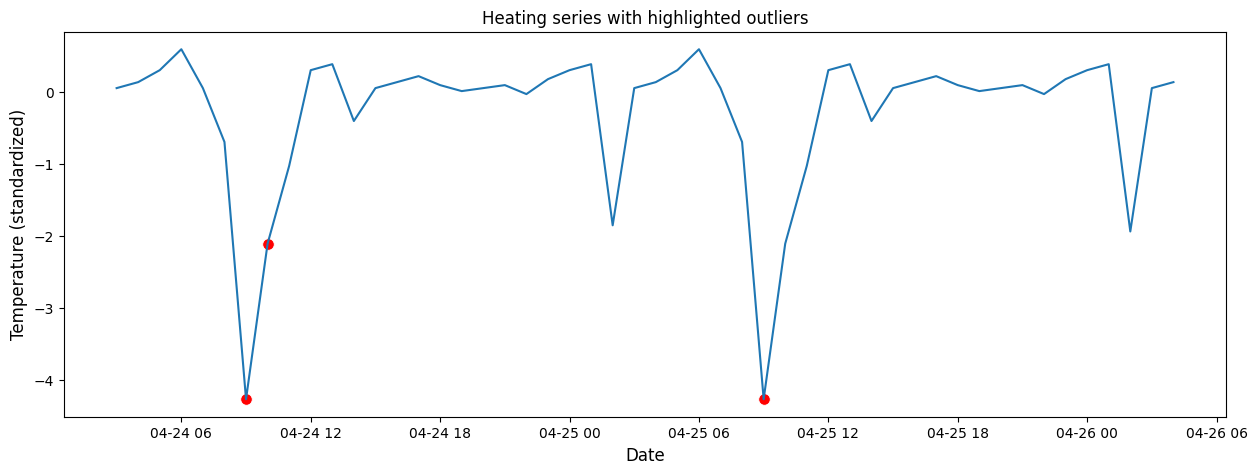

In [63]:
zoom = df_final.iloc[250:300,:]
plt.figure(figsize=(15,5))
g = sns.lineplot(zoom, x='datetime', y='temperature_heating')
sns.scatterplot(zoom[(zoom["outlier"] == True)], x='datetime', y='temperature_heating', color='red', s=70, marker='o')
g.set_title("Heating series with highlighted outliers")
g.set_xlabel("Date", size=12)
g.set_ylabel("Temperature (standardized)", size=12)

In [64]:
n_outliers = len(df_final[df_final.outlier == True])
ratio = np.round(n / n_outliers, 2)
print(f"In total we detected {n_outliers} potential anomalies for the heating temperature. Ratio: {ratio} %")

In total we detected 376 potential anomalies for the heating temperature. Ratio: 18.23 %


Certinaly, an anomaly ratio of above five percent is quite high. As a next step, all parts of the process could be refined, including a better sampling for missing values, refining the modelling process, as well as investigating further Machine Learning approaches.

<b>Thank you for reading till the end 🙂</b>